In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr, pointbiserialr
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

**locations_xxxx** files: contain the raw-ttc-location and cleansed-location values.\
**ttc-bus-delay-data-xxxx** files: contain the raw data from the ttc.\
**coordinates** file: contains the coordinates found for some of the cleansed locations.\
**en_climate_daily_ON_6158355_xxxx_P1D** files: contains the weather data of the TORONTO CITY station.

In [2]:
doc_loc_2024 = pd.read_csv('datests/locations_2024.csv', index_col=False)
doc_loc_2023 = pd.read_csv('datests/locations_2023.csv', index_col=False)
doc_loc_2022 = pd.read_csv('datests/locations_2022.csv', index_col=False)

doc_ttc_2024 = pd.read_csv('datests/ttc-bus-delay-data-2024.csv', index_col=False)
doc_ttc_2023 = pd.read_csv('datests/ttc-bus-delay-data-2023.csv', index_col=False)
doc_ttc_2022 = pd.read_csv('datests/ttc-bus-delay-data-2022.csv', index_col=False)

doc_weather_2022 = pd.read_csv('datests/en_climate_daily_ON_6158355_2022_P1D.csv')
doc_weather_2023 = pd.read_csv('datests/en_climate_daily_ON_6158355_2023_P1D.csv')
doc_weather_2024 = pd.read_csv('datests/en_climate_daily_ON_6158355_2024_P1D.csv')
columns_to_keep = ['Date/Time','Month','Mean Temp (°C)','Total Precip (mm)']
doc_weather_2024 = doc_weather_2024[columns_to_keep].copy()
doc_weather_2023 = doc_weather_2023[columns_to_keep].copy()
doc_weather_2022 = doc_weather_2022[columns_to_keep].copy()


df_complete_loc = pd.concat([doc_loc_2024,doc_loc_2023,doc_loc_2022], ignore_index=True)
df_coordinates = pd.read_csv('datests/coordinates.csv')
df_complete_weather = pd.concat([doc_weather_2024,doc_weather_2023,doc_weather_2022], ignore_index=True)
df_complete_ttc = pd.concat([doc_ttc_2024,doc_ttc_2023,doc_ttc_2022], ignore_index=True)

df_complete_ttc.Location = df_complete_ttc.Location.apply(lambda x: x.lower())
df_complete_weather['Date/Time'] = pd.to_datetime(df_complete_weather['Date/Time'], format = "%Y-%m-%d")


In [3]:
df_merged = df_complete_loc.merge(df_coordinates, on='new', how='left').dropna()
df_merged.rename(columns={'original':'Location','lat':'Lat','lon':'Lon'}, inplace=True)

In [4]:
df_merged2 = df_complete_ttc.merge(df_merged, on='Location', how='left')
df_merged2 = df_merged2[df_merged2.new.notna()].copy()

df_merged2.drop(columns=['Location'], inplace=True)
df_merged2.rename(columns = {'new':'Location'}, inplace=True)
df_merged2.Date = pd.to_datetime(df_merged2.Date, format = "%d-%b-%y")

df_complete = df_merged2.merge(df_complete_weather, left_on='Date', right_on='Date/Time')
df_complete.drop(columns=['Date/Time'], inplace=True)
df_complete.Time = df_complete.Time.apply(lambda x: int(x.split(':')[0]))
df_complete.rename(columns={'Time':'Day Hour'}, inplace=True)

### Description of the Dataset

It contains 15 columns.\
11 features, 1 target, and the date.\
*Vehicle* shouldn't be necessary because if the amount of different vehicles.
*Location* is already known by the lat and lon. 

In [5]:
df_complete.head()

,Date,Route,Day Hour,Day,Incident,Min Delay,Min Gap,Direction,Vehicle,Location,Lat,Lon,Month,Mean Temp (°C),Total Precip (mm)
0,2024-01-01,65,3,Monday,Security,0,0,N,8574,parliament & bloor,43.672151,-79.370772,1,-1.9,0.1
1,2024-01-01,65,3,Monday,Security,0,0,N,8574,parliament & bloor,43.672151,-79.370772,1,-1.9,0.1
2,2024-01-01,65,3,Monday,Security,0,0,N,8574,parliament & bloor,43.672151,-79.370772,1,-1.9,0.1
3,2024-01-01,320,3,Monday,Operations - Operator,8,16,N,8192,yonge & queens quay east,43.642201,-79.374193,1,-1.9,0.1
4,2024-01-01,300,4,Monday,Security,10,20,W,3335,danforth & woodbine,43.685725,-79.312029,1,-1.9,0.1


In [6]:
len(df_complete)

181230

### The min delay

In [7]:
print('number of missing values',df_complete['Min Delay'].isna().sum())
print('maximum value:' , max(df_complete['Min Delay']))
print('minimum value:' , min(df_complete['Min Delay']))
print('number of 0:' , len(df_complete[df_complete['Min Delay']==0]))
min_delay = 60
print(f'number delays longer than {min_delay}:' , len(df_complete[df_complete['Min Delay']>min_delay]))

number of missing values 0
maximum value: 999
minimum value: 0
number of 0: 14065
number delays longer than 60: 9321


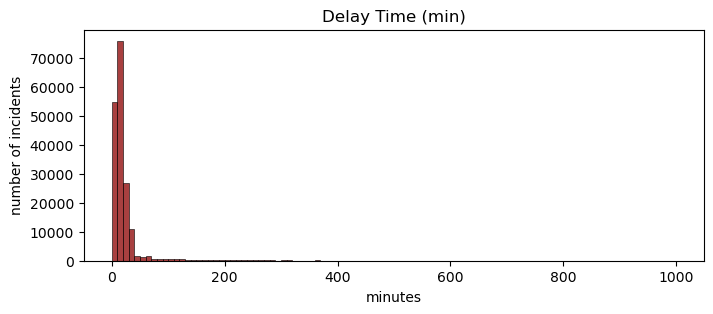

In [8]:
fig, ax = plt.subplots(figsize = (8,3))
sns.histplot(x= df_complete['Min Delay'],ax=ax, color= 'darkred', bins=100)
plt.title('Delay Time (min)')
plt.xlabel('minutes')
plt.ylabel('number of incidents')
plt.show()

Scaling the min delay with square root

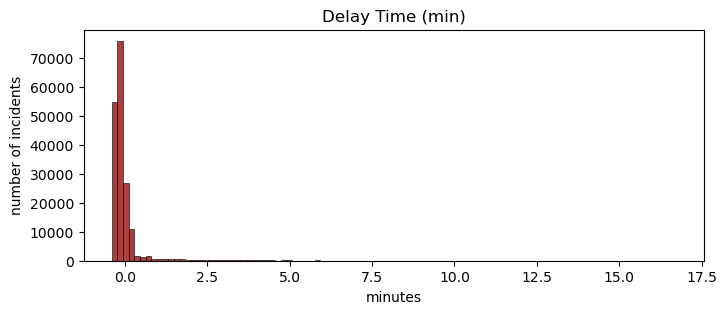

In [9]:
fig, ax = plt.subplots(figsize = (8,3))
scaling = df_complete['Min Delay'].to_numpy().reshape(-1,1)
scaling_1 = StandardScaler()
min_delay = scaling_1.fit_transform(scaling).flatten()

sns.histplot(x= min_delay,ax=ax, color= 'darkred', bins=100)
plt.title('Delay Time (min)')
plt.xlabel('minutes')
plt.ylabel('number of incidents')
plt.show()

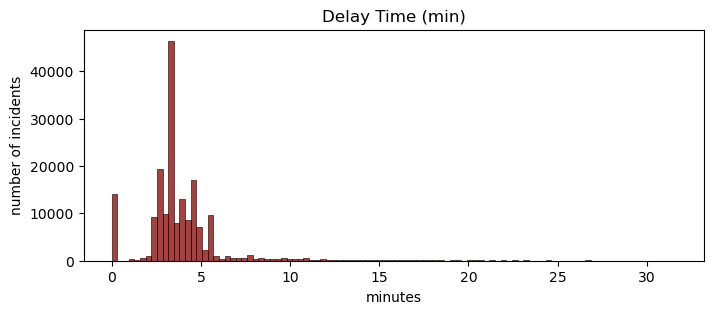

In [10]:
fig, ax = plt.subplots(figsize = (8,3))
sns.histplot(x= df_complete['Min Delay'].apply(np.sqrt),ax=ax, color= 'darkred', bins=100)
plt.title('Delay Time (min)')
plt.xlabel('minutes')
plt.ylabel('number of incidents')
plt.show()

Disregarding the 0 values

In [11]:
df_complete = df_complete[~(df_complete['Min Delay']==0)]
print(len(df_complete))

167165


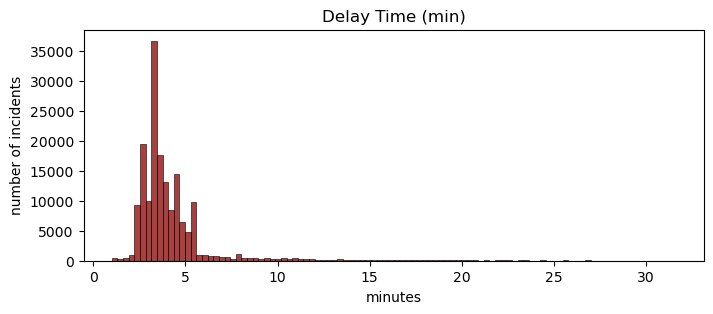

In [12]:
fig, ax = plt.subplots(figsize = (8,3))
sns.histplot(x= df_complete['Min Delay'].apply(np.sqrt),ax=ax, color= 'darkred', bins=100)
plt.title('Delay Time (min)')
plt.xlabel('minutes')
plt.ylabel('number of incidents')
plt.show()

Considering all the values higher than 60 min as 60 min exactly

In [13]:
df_complete.loc[df_complete['Min Delay']>120,'Min Delay'] = 120
df_complete['Min Delay'] = df_complete['Min Delay'].apply(np.sqrt)

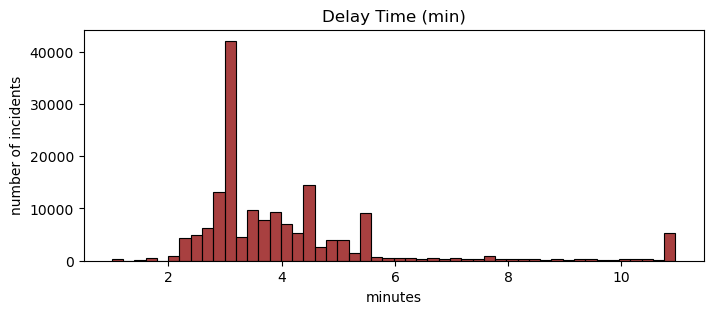

In [14]:
fig, ax = plt.subplots(figsize = (8,3))
sns.histplot(x= df_complete['Min Delay'],ax=ax, color= 'darkred', bins=50)
plt.title('Delay Time (min)')
plt.xlabel('minutes')
plt.ylabel('number of incidents')
plt.show()

### The Day

There are no missing values

In [15]:
df_complete.Day.isna().sum()

0

**Total Number of incidets per day**

The samples seem to be well distributed (balanced) accross all the days of the week

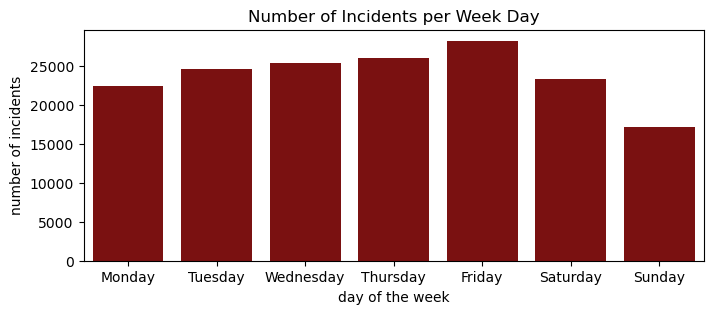

In [16]:
day_distribution = df_complete.Day.value_counts()

fig, ax = plt.subplots(figsize = (8,3))
sns.barplot(x= day_distribution.index, y= day_distribution.values,ax=ax, color= 'darkred', order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.title('Number of Incidents per Week Day')
plt.xlabel('day of the week')
plt.ylabel('number of incidents')
plt.show()

**Distribution of Delay Minutes per Week Day**

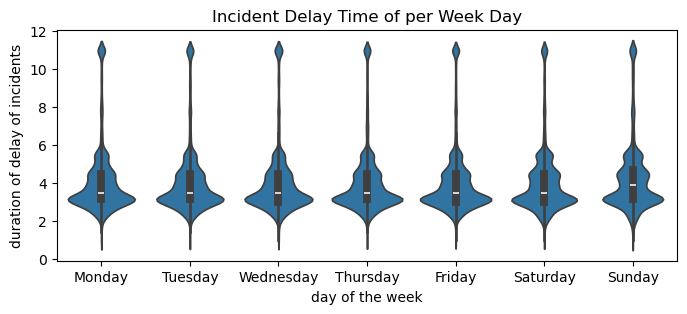

In [17]:
fig, ax = plt.subplots(figsize = (8,3))
sns.violinplot(data=df_complete, x="Day", y="Min Delay", ax=ax)
ax.set_title('Incident Delay Time of per Week Day')
plt.xlabel('day of the week')
plt.ylabel('duration of delay of incidents')
plt.show()

**Encoding days of the week**

In [18]:
le = OrdinalEncoder()
order_week_day = [['Monday'],['Tuesday'],['Wednesday'],['Thursday'],['Friday'],['Saturday'],['Sunday']]
le.fit(order_week_day)
df_complete.Day = le.transform(df_complete.Day.to_numpy().reshape(-1,1)).flatten()

### Incident

**Total Number of incidets per Type of Incident**

The incidents are very inbalanced. Spectially for: Held By, Late Entering Service, and Cleaning - Disinfection.
* Let's consider *Cleaning - Unsanitary* to be the same as *Cleaning - Unsanitary*.
* Let's disregard the last 2 labels.

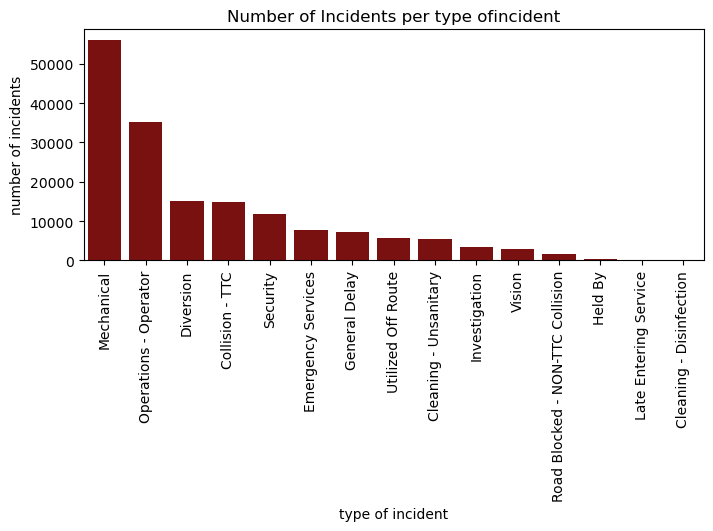

Incident
Mechanical                          55933
Operations - Operator               35266
Diversion                           15110
Collision - TTC                     14902
Security                            11909
Emergency Services                   7595
General Delay                        7176
Utilized Off Route                   5742
Cleaning - Unsanitary                5344
Investigation                        3341
Vision                               2913
Road Blocked - NON-TTC Collision     1677
Held By                               231
Late Entering Service                  20
Cleaning - Disinfection                 6
Name: count, dtype: int64


In [19]:
day_distribution = df_complete.Incident.value_counts()

fig, ax = plt.subplots(figsize = (8,3))
sns.barplot(x= day_distribution.index, y= day_distribution.values,ax=ax, color= 'darkred')
plt.title('Number of Incidents per type ofincident')
plt.xlabel('type of incident')
ax.tick_params(axis='x', rotation=90)  
plt.ylabel('number of incidents')
plt.show()
print(day_distribution)

Droping the 2 least significats and replacing the cleaning

In [20]:
df_complete = df_complete[~df_complete.Incident.isin(['Held By','Late Entering Service'])]
df_complete.replace({'Cleaning - Disinfection':'Cleaning - Unsanitary'},inplace=True)

**Minutes of Delay per Type of Incident**

Diversion seems to be the one with longer delays

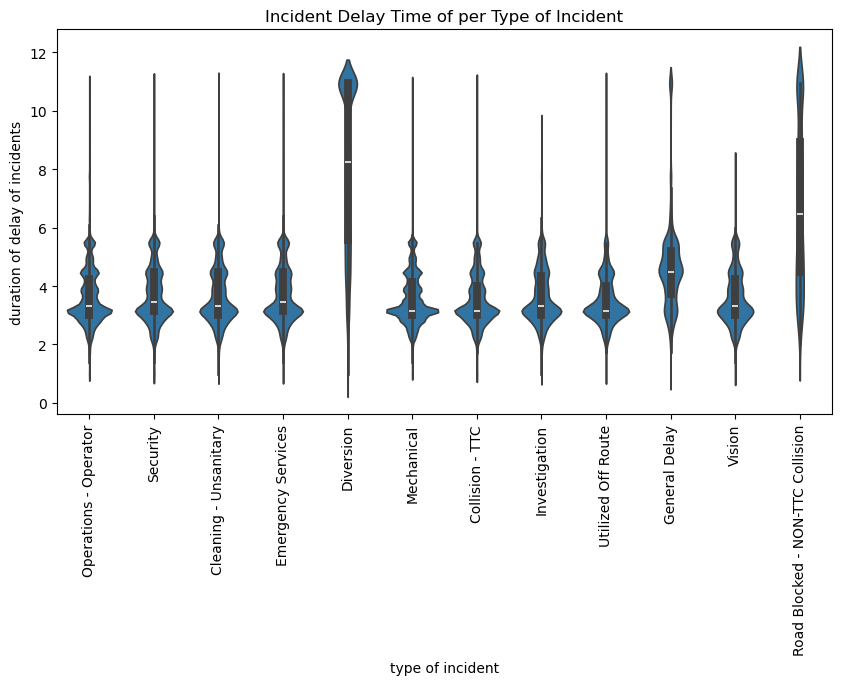

In [21]:
fig, ax = plt.subplots(figsize = (10,5))
sns.violinplot(data=df_complete, x="Incident", y="Min Delay", ax=ax)
ax.set_title('Incident Delay Time of per Type of Incident')
plt.xlabel('type of incident')
ax.tick_params(axis='x', rotation=90)  
plt.ylabel('duration of delay of incidents')
plt.show()

In [22]:
le_inc = LabelEncoder()
order_incident_type = df_complete.Incident.unique()
le_inc.fit(order_incident_type)
df_complete.Incident = le_inc.transform(df_complete.Incident)

### Month

**Total Number of incidets per Month**

The incidents are evenly spread in each month

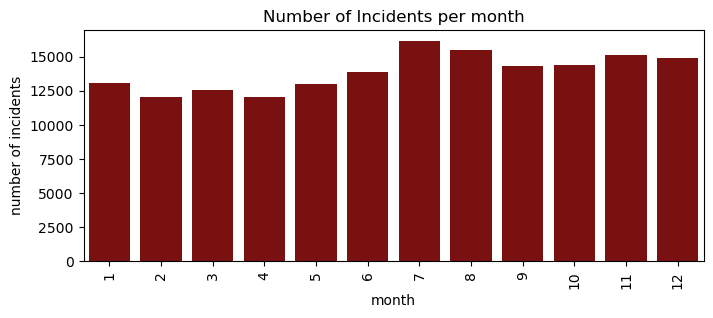

In [23]:
month_distribution = df_complete.Month.value_counts()

fig, ax = plt.subplots(figsize = (8,3))
sns.barplot(x= month_distribution.index, y= month_distribution.values,ax=ax, color= 'darkred')
plt.title('Number of Incidents per month')
plt.xlabel('month')
ax.tick_params(axis='x', rotation=90)  
plt.ylabel('number of incidents')
plt.show()

**Minutes of Delay per month**

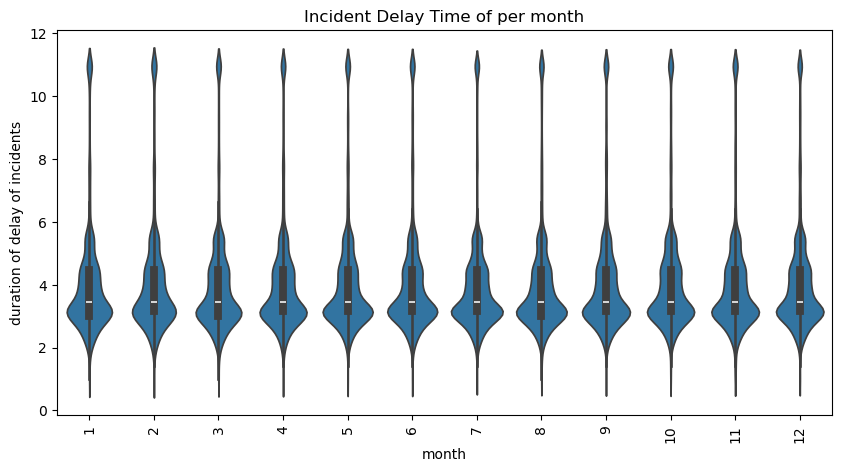

In [24]:
fig, ax = plt.subplots(figsize = (10,5))
sns.violinplot(data=df_complete, x="Month", y="Min Delay", ax=ax)
ax.set_title('Incident Delay Time of per month')
plt.xlabel('month')
ax.tick_params(axis='x', rotation=90)  
plt.ylabel('duration of delay of incidents')
plt.show()

### Temperature

**Distribution incidets regarding Temperature**

The incidents seems to have a relationship with the temperature of the city

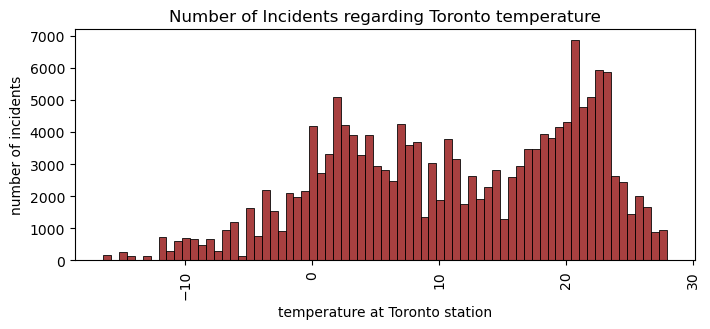

In [25]:
fig, ax = plt.subplots(figsize = (8,3))
sns.histplot(x= df_complete['Mean Temp (°C)'],ax=ax, color= 'darkred')
plt.title('Number of Incidents regarding Toronto temperature')
plt.xlabel('temperature at Toronto station')
ax.tick_params(axis='x', rotation=90)  
plt.ylabel('number of incidents')
plt.show()

**Minutes of Delay vs temperature**

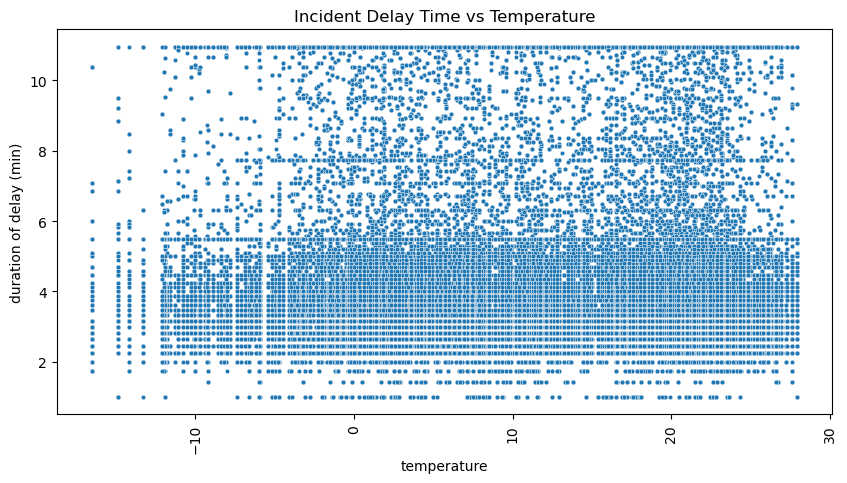

In [26]:
fig, ax = plt.subplots(figsize = (10,5))
sns.scatterplot(data=df_complete, x="Mean Temp (°C)", y="Min Delay", ax=ax, s=10)
ax.set_title('Incident Delay Time vs Temperature')
plt.xlabel('temperature')
ax.tick_params(axis='x', rotation=90)  
plt.ylabel('duration of delay (min)')
plt.show()

### Total Precip (mm)

There are null values. Becuase the dataset is huge, we could disregard those samples

In [27]:
df_complete['Total Precip (mm)'].isna().sum()

840

In [28]:
df_complete = df_complete[~df_complete['Total Precip (mm)'].isna()].copy()

**Distribution incidets regarding Total Precip (mm)**

It seems that 59% of the cases didn't rain

In [29]:
len(df_complete[df_complete['Total Precip (mm)'] == 0])/len(df_complete)

0.5940123077664173

Due to the distribution, we can consider split the data as *rain* or *no rain*

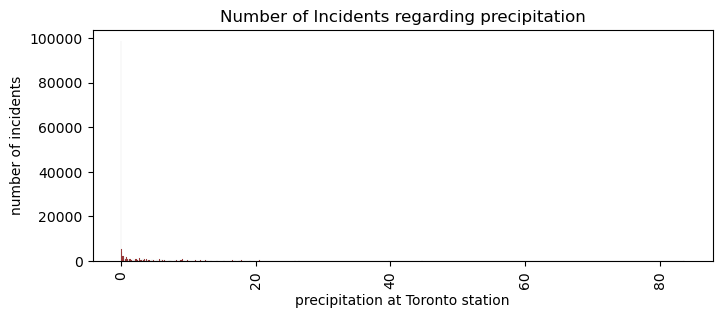

In [30]:
fig, ax = plt.subplots(figsize = (8,3))
sns.histplot(x= df_complete['Total Precip (mm)'],ax=ax, color= 'darkred')
plt.title('Number of Incidents regarding precipitation')
plt.xlabel('precipitation at Toronto station')
ax.tick_params(axis='x', rotation=90)  
plt.ylabel('number of incidents')
plt.show()

Defining the label rain

In [31]:
df_complete.loc[df_complete['Total Precip (mm)'] > 0,'Total Precip (mm)'] = 1
df_complete.rename(columns={'Total Precip (mm)':'Precipitation'},inplace=True)

**Minutes of Delay vs Precipitation**

There seems to be a higher mean when it rains

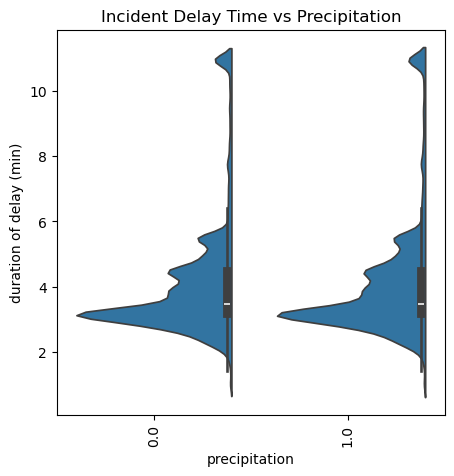

In [32]:
fig, ax = plt.subplots(figsize = (5,5))
sns.violinplot(data=df_complete, x="Precipitation", y="Min Delay", ax=ax, split=True)
ax.set_title('Incident Delay Time vs Precipitation')
plt.xlabel('precipitation')
ax.tick_params(axis='x', rotation=90)  
plt.ylabel('duration of delay (min)')
plt.show()

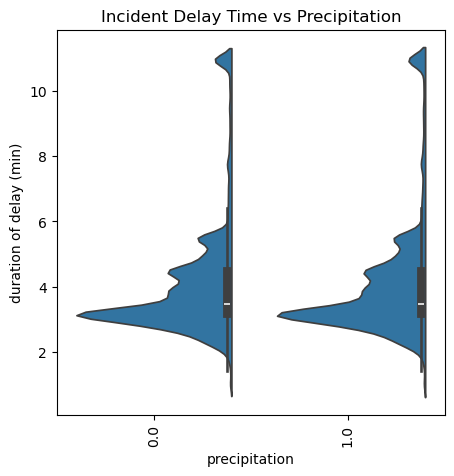

In [33]:
fig, ax = plt.subplots(figsize = (5,5))
sns.violinplot(data=df_complete, x="Precipitation", y="Min Delay", ax=ax, split=True)
ax.set_title('Incident Delay Time vs Precipitation')
plt.xlabel('precipitation')
ax.tick_params(axis='x', rotation=90)  
plt.ylabel('duration of delay (min)')
plt.show()

### Day Hour

Most of the incidents seem to happen in the evening

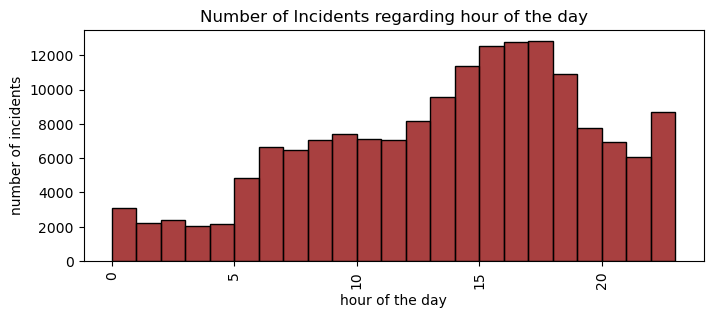

In [34]:
fig, ax = plt.subplots(figsize = (8,3))
sns.histplot(x= df_complete['Day Hour'],ax=ax, color= 'darkred', bins=23)
plt.title('Number of Incidents regarding hour of the day')
plt.xlabel('hour of the day')
ax.tick_params(axis='x', rotation=90)  
plt.ylabel('number of incidents')
plt.show()

It seems that the largest delay happen in the morning

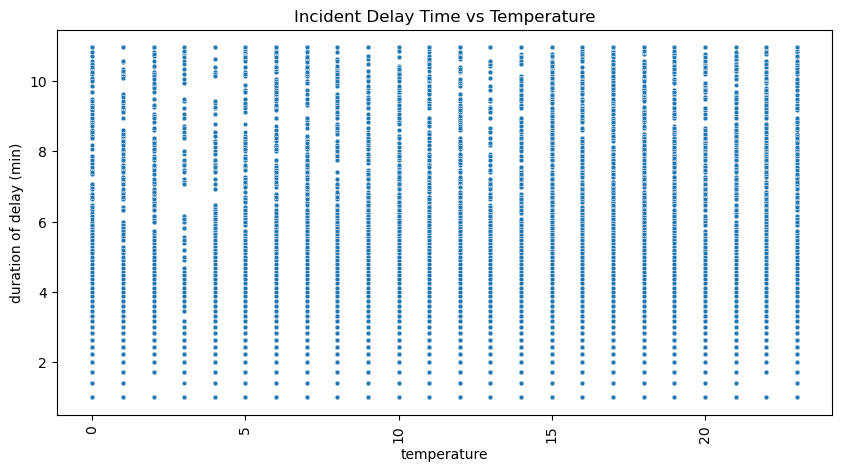

In [35]:
fig, ax = plt.subplots(figsize = (10,5))
sns.scatterplot(data=df_complete, x="Day Hour", y="Min Delay", ax=ax, s=10)
ax.set_title('Incident Delay Time vs Temperature')
plt.xlabel('temperature')
ax.tick_params(axis='x', rotation=90)  
plt.ylabel('duration of delay (min)')
plt.show()

### Route

There are missing values

In [36]:
df_complete.Route.isna().sum()

326

Eliminating the missing values

In [37]:
df_complete = df_complete[~df_complete.Route.isna()].copy()

Transforming the routes that are not numbers into numbers

In [38]:
routes = df_complete.Route.unique()

In [39]:
values_to_replace = {}
value = 560 
for i in routes:
    try:
        int(i)
    except:
        values_to_replace[i] = f'{value}'
        value += 1
print(values_to_replace)

df_complete['Route'] = df_complete['Route'].replace(values_to_replace)
df_complete.Route = df_complete['Route'].apply(int)

{'LESLIE': '560', 'BATHURST': '561', 'LINE 2': '562', 'SHUTTLE': '563', 'LINE 1': '564', 'RAD 600': '565', 'RAD': '566', 'LINE 3': '567', 'CARIBANA': '568', 'SRT': '569', '927 HIGHWAY 27': '570', '600 (75': '571', '939 FINCH EXPRESS / 39': '572', 'OTC': '573'}


<Axes: xlabel='Route', ylabel='Count'>

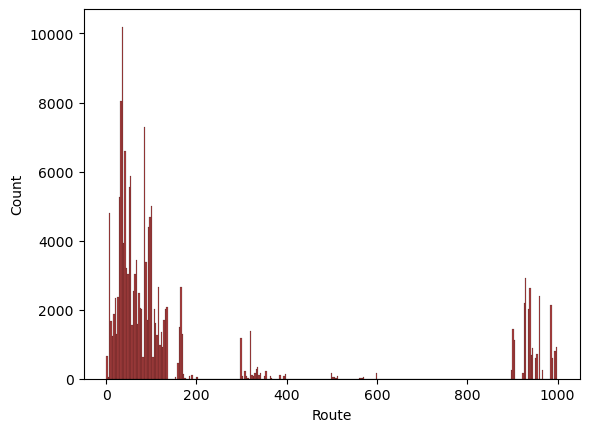

In [40]:
sns.histplot(df_complete['Route'], color= 'darkred')


### Lat and Lon

It seems a normal distribution regarding the latitude

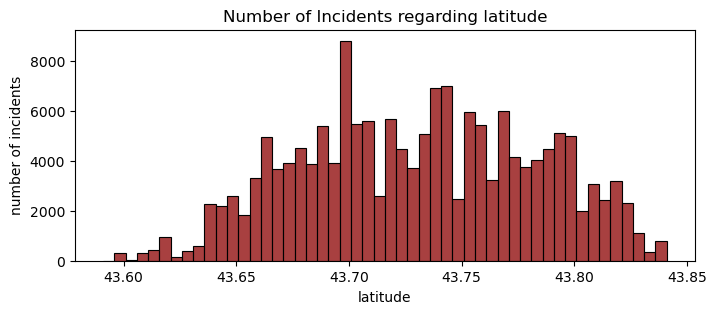

In [41]:
fig, ax = plt.subplots(figsize = (8,3))
sns.histplot(x= df_complete['Lat'],ax=ax, color= 'darkred', bins=50)
plt.title('Number of Incidents regarding latitude')
plt.xlabel('latitude')
plt.ylabel('number of incidents')
plt.show()

It seems a bimodal distribution for the longitude

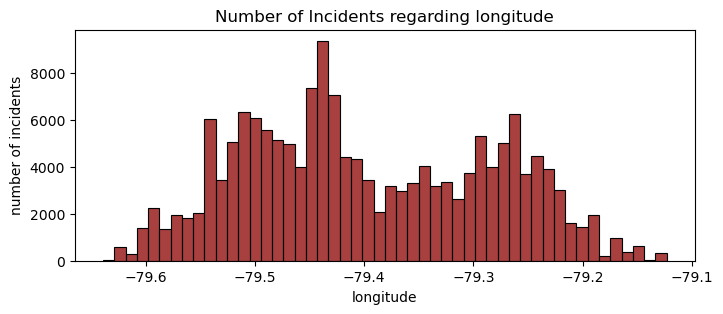

In [42]:
fig, ax = plt.subplots(figsize = (8,3))
sns.histplot(x= df_complete['Lon'],ax=ax, color= 'darkred', bins =  50)
plt.title('Number of Incidents regarding longitude')
plt.xlabel('longitude')
plt.ylabel('number of incidents')
plt.show()

Similar distribution regarding the duration of the delay

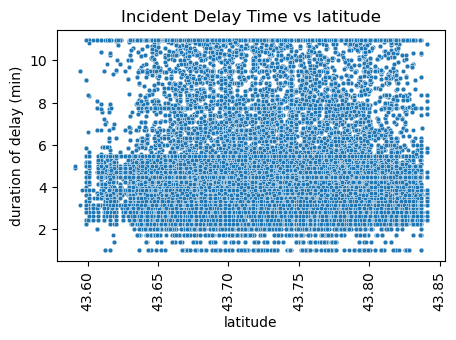

In [43]:
fig, ax = plt.subplots(figsize = (5,3))
sns.scatterplot(data=df_complete, x="Lat", y="Min Delay", ax=ax, s=10)
ax.set_title('Incident Delay Time vs latitude')
plt.xlabel('latitude')
ax.tick_params(axis='x', rotation=90)  
plt.ylabel('duration of delay (min)')
plt.show()

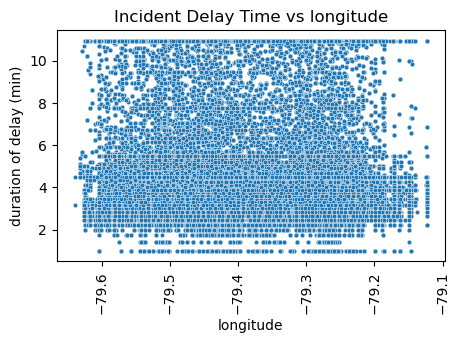

In [44]:
fig, ax = plt.subplots(figsize = (5,3))
sns.scatterplot(data=df_complete, x="Lon", y="Min Delay", ax=ax, s=10)
ax.set_title('Incident Delay Time vs longitude')
plt.xlabel('longitude')
ax.tick_params(axis='x', rotation=90)  
plt.ylabel('duration of delay (min)')
plt.show()

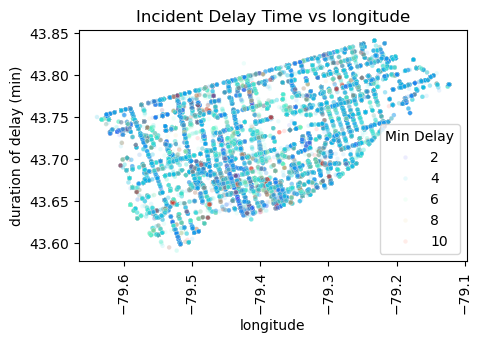

In [45]:
fig, ax = plt.subplots(figsize = (5,3))
sns.scatterplot(data=df_complete, x="Lon", y="Lat", ax=ax, hue='Min Delay', alpha = 0.1,palette='rainbow', s=10)
ax.set_title('Incident Delay Time vs longitude')
plt.xlabel('longitude')
ax.tick_params(axis='x', rotation=90)  
plt.ylabel('duration of delay (min)')
plt.show()

# Dataframe for the machine learning model

Consider that Min Delay is scaled by a root square

In [46]:
df_complete_ml = df_complete[['Day Hour','Day','Month','Incident','Lat','Lon','Mean Temp (°C)','Precipitation','Min Delay']].copy()

In [47]:
df_complete_ml['Incident'].value_counts()

Incident
6     55569
7     35078
2     14984
1     14776
9     11780
3      7536
4      7143
10     5693
0      5312
5      3331
11     2881
8      1665
Name: count, dtype: int64

In [48]:
df_complete_ml

,Day Hour,Day,Month,Incident,Lat,Lon,Mean Temp (°C),Precipitation,Min Delay
3,3,1.0,1,7,43.642201,-79.374193,-1.9,1.0,2.828427
4,4,1.0,1,9,43.685725,-79.312029,-1.9,1.0,3.162278
5,4,1.0,1,9,43.685725,-79.312029,-1.9,1.0,3.162278
6,4,1.0,1,9,43.685725,-79.312029,-1.9,1.0,3.162278
7,4,1.0,1,0,43.678803,-79.297838,-1.9,1.0,5.477226
...,...,...,...,...,...,...,...,...,...
181225,23,2.0,12,2,43.641326,-79.376989,7.4,1.0,10.954451
181226,23,2.0,12,2,43.641326,-79.376989,7.4,1.0,10.954451
181227,23,2.0,12,11,43.688930,-79.296370,7.4,1.0,4.472136
181228,23,2.0,12,11,43.688930,-79.296370,7.4,1.0,4.472136


Considering that the type of incident is unbalanced, we could take a balanced sample from the population to train

In [49]:
incident_size = 1665 # 1677 is the count for the smallest type of incident
balanced_sample = df_complete_ml.groupby('Incident', group_keys=False)\
                                    .apply(lambda x: x.sample(n=incident_size, random_state=42))\
                                    .reset_index(drop=True)

In [50]:
balanced_sample.Incident.value_counts()

Incident
0     1665
1     1665
2     1665
3     1665
4     1665
5     1665
6     1665
7     1665
8     1665
9     1665
10    1665
11    1665
Name: count, dtype: int64

In [51]:
len(df_complete_ml)

165748

In [52]:
len(balanced_sample)

19980

### Model Training & Hyperparameter Tuning

### NN

### Experimenting with different # of Hidden layers and different # of Neurons per hidden layers, also utlizing various Learning Rates

Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.

NN1_LR_0.1 with LR 0.1:
Train MSE: 0.9787
Validation MSE: 0.9911
Test MSE: 0.9758
Epoch 32: early stopping
Restoring model weights from the end of the best epoch: 22.

NN1_LR_0.01 with LR 0.01:
Train MSE: 0.8864
Validation MSE: 0.8992
Test MSE: 0.8899
Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 14.

NN1_LR_0.001 with LR 0.001:
Train MSE: 0.7243
Validation MSE: 0.7393
Test MSE: 0.7273
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 2.

NN2_LR_0.1 with LR 0.1:
Train MSE: 1.0264
Validation MSE: 1.0384
Test MSE: 1.0291
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 10.

NN2_LR_0.01 with LR 0.01:
Train MSE: 0.5435
Validation MSE: 0.5575
Test MSE: 0.5426
Epoch 59: early stopping
Restoring model weights from the end of the best epoch: 49.

NN2_LR_0.001 with LR 0.001:
Train MSE: 0.5242
Validation MSE: 0.5388

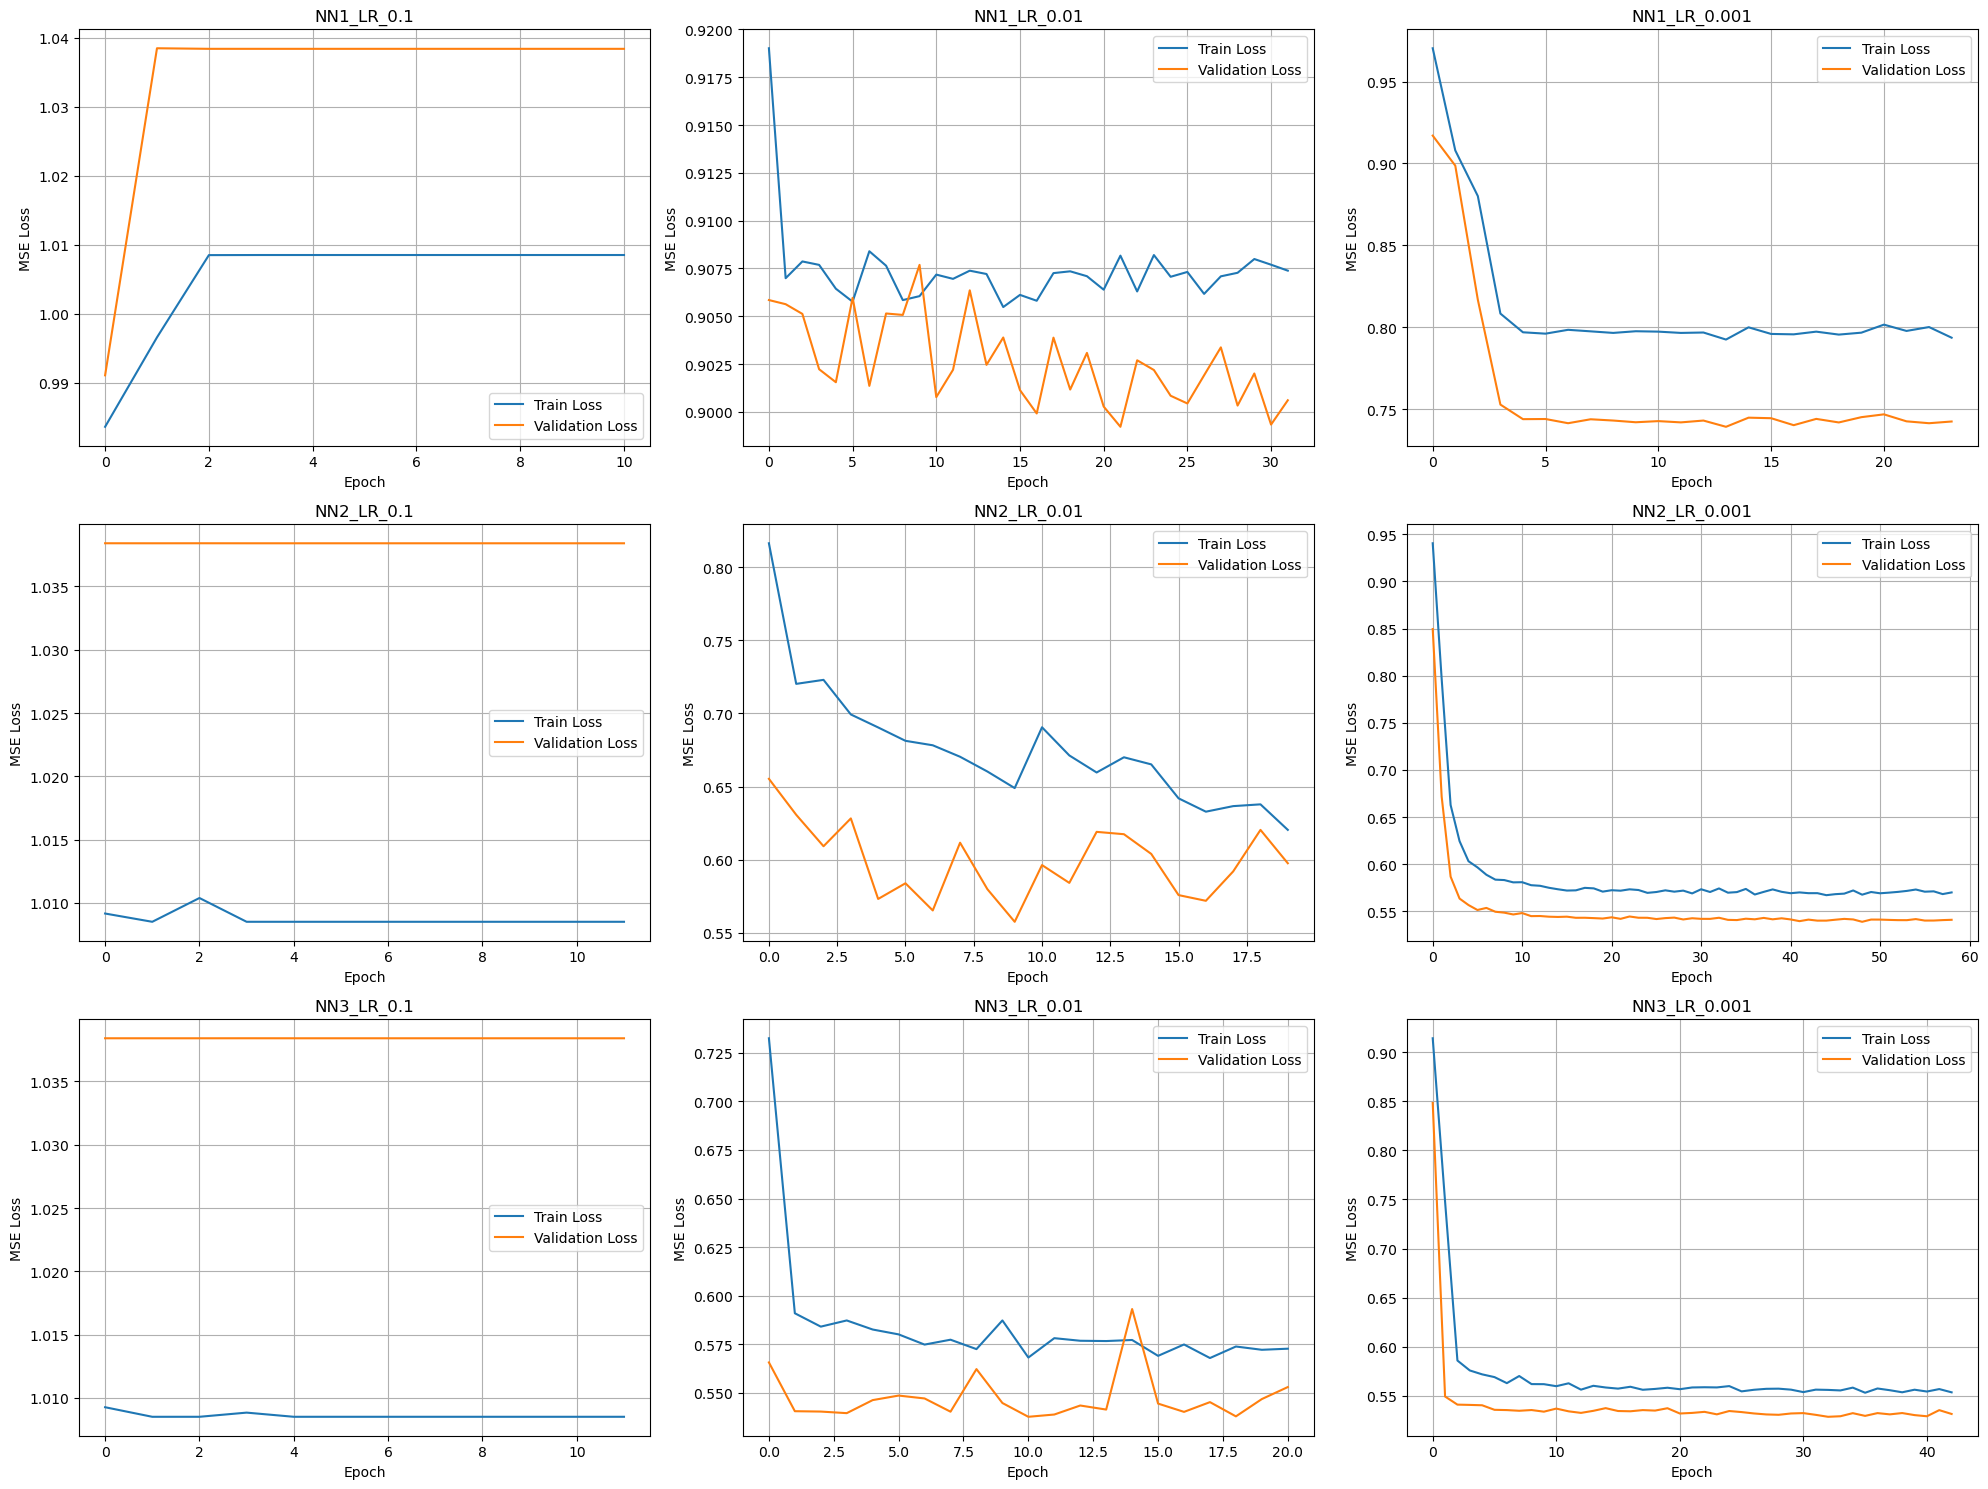


Best Model: NN3_LR_0.001
Best Validation Loss (MSE): 0.5288
777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step

Final Test MSE: 1.6792


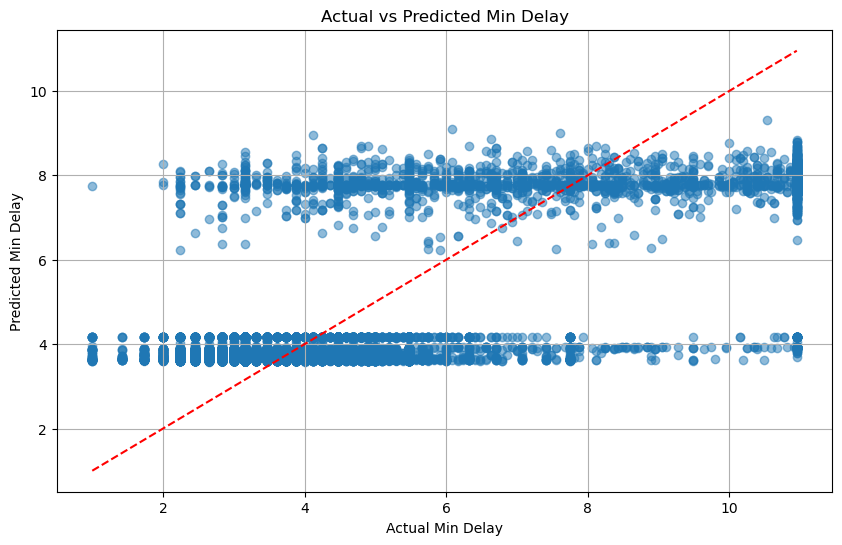


All files saved in: C:/Users/Asif/Jupyter Notebook/TTC


In [60]:
SAVE_PATH = r'C:/Users/Asif/Jupyter Notebook/TTC'

os.makedirs(SAVE_PATH, exist_ok=True)

### Setting the random seed to 42 for reproducibility

np.random.seed(42)

tf.random.set_seed(42)


### Using the unbalacned dataset for this experiments

df = df_complete_ml


### Picking all the features of the NN 

X = df[['Day Hour', 'Day', 'Month', 'Incident', 'Lat', 'Lon', 'Mean Temp (°C)', 'Precipitation']]

### Target variable of the model which is the Minimum Delay

y = df['Min Delay']


### Splittng the dataset into Training + Validation = 85%, Testing = 15%

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

### Then again splittng the 85% into Validation Set = 17.65% of 85% = 15% of the original & Training Set = 82.35% of 85% = 70% of the original

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)


### Performing standard scaling 

scaler_X = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)

X_val_scaled = scaler_X.transform(X_val)

X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()


### Ensuring the target variable (y_train_scaled) is in the correct 1D shape

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()

y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)).flatten()

y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()


### Using EarlyStopping mechanism to prevent overfitting & underfitting 

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)


### Experiemnting with a list of Learning rates to find optimal Learning rate

learning_rates = [0.1, 0.01, 0.001]


### Defining a create_and_train_model to load or create a model. 

### If the fucntion returns None then it menas that a existing model was not loaded or found in the path,so create a new model


def create_and_train_model(model_name, hidden_layers, learning_rate, X_train, y_train, X_val, y_val, X_test, y_test):
    
    model_path = os.path.join(SAVE_PATH, f'{model_name}_model.keras')
    
    if os.path.exists(model_path):
        
        try:
            
            print(f"Loading existing model: {model_name}")
            
            model = tf.keras.models.load_model(model_path, compile=False)

            ### Using Adam as a optimizer
            
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

            
            ### Using MSE as the loss fucntion as well as the metrics
            
            model.compile(optimizer=optimizer, 
                          loss='mean_squared_error', 
                          metrics=['mse'])
            
            return model, None

        
        except Exception as e:
            
            print(f"Error loading model: {e}. Creating new model.")
            
    
    model = Sequential(name=model_name)
    

    ### hidden_layers[0] is the # of neurons in 1st hidden layer

    ### Using ReLU a the activatiion function in the hidden layers

    ### input_shape=(X_train.shape[1],) means how many input features are there for the model
    
    
    model.add(Dense(hidden_layers[0], activation='relu', input_shape=(X_train.shape[1],)))
    

    ### Using dropout of 20% of neurons during training to prevent overfitting
    
    
    model.add(Dropout(0.2))

    
    ### hidden_layers[1:] is the slice starting from the second element anf the loop will add the rest of the hidden layers if there is any
    
    
    for units in hidden_layers[1:]:
        
        model.add(Dense(units, activation='relu'))
        
        model.add(Dropout(0.2))
    
    model.add(Dense(1))  
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])
    

    ### Saving the model weights to the specific path

    
    checkpoint_path = os.path.join(SAVE_PATH, f'{model_name}_checkpoint.weights.h5')
    
    checkpoint = ModelCheckpoint(
        
        checkpoint_path, 
        save_weights_only=True, 
        save_best_only=True, 
        monitor='val_loss', 
        mode='min'
        
    )
    
    history = model.fit(
        
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, checkpoint],
        verbose=0
        
    )
    
    model.save(model_path)
    
    train_loss = model.evaluate(X_train, y_train, verbose=0)[0]
    
    val_loss = model.evaluate(X_val, y_val, verbose=0)[0]
    
    test_loss = model.evaluate(X_test, y_test, verbose=0)[0]
    
    print(f"{model_name} with LR {learning_rate}:")
    
    print(f"Train MSE: {train_loss:.4f}")
    
    print(f"Validation MSE: {val_loss:.4f}")
    
    print(f"Test MSE: {test_loss:.4f}")
    
    return model, history

results = []
best_models = {}

for lr in learning_rates:
    
    model_name = f"NN1_LR_{lr}"
    
    model, history = create_and_train_model(
        
        model_name, 

        ### Number of neurons in the hidden layer, 8 neurons
        
        [8], 
        
        lr,
        
        X_train_scaled, y_train_scaled, 
        X_val_scaled, y_val_scaled,
        X_test_scaled, y_test_scaled
    )
    
    results.append({
        
        'model_name': model_name,
        'lr': lr,
        'history': history,
        'model': model
        
    })

for lr in learning_rates:
    model_name = f"NN2_LR_{lr}"
    
    model, history = create_and_train_model(
        
        model_name, 

        ### Number of neurons in the hidden layer, 16 neurons in the 1st hidden layer, 8 neurons in the 2nd hidden layer
        
        [16, 8],
        
        lr,
        
        X_train_scaled, y_train_scaled, 
        X_val_scaled, y_val_scaled,
        X_test_scaled, y_test_scaled
    )
    
    results.append({
        
        'model_name': model_name,
        'lr': lr,
        'history': history,
        'model': model
        
    })

for lr in learning_rates:
    model_name = f"NN3_LR_{lr}"
    
    model, history = create_and_train_model(
        
        model_name, 

        ### Number of neurons in the hidden layer, 32 neurons in the 1st hidden layer, 16 neurons in the 2nd hidden layer, 8 neurons in the 3rd hidden layer 
        
        [32, 16, 8], 
        
        lr,
        X_train_scaled, y_train_scaled, 
        X_val_scaled, y_val_scaled,
        X_test_scaled, y_test_scaled
    )
    
    results.append({
        
        'model_name': model_name,
        'lr': lr,
        'history': history,
        'model': model
        
    })


### Plot the learning curve and save it in the path

plt.figure(figsize=(20, 15))

for i, result in enumerate(results):
    
    if result['history'] is not None:
        
        plt.subplot(3, 3, i+1)
        plt.plot(result['history'].history['loss'], label='Train Loss')
        plt.plot(result['history'].history['val_loss'], label='Validation Loss')
        plt.title(f"{result['model_name']}")
        plt.xlabel('Epoch')
        plt.ylabel('MSE Loss')
        plt.legend()
        plt.grid(True)
        
plt.tight_layout()

plt.savefig(os.path.join(SAVE_PATH, 'learning_curves.png'))

plt.show()


### Selecting the best model

best_result = min(
    
    [r for r in results if r['history'] is not None], 
    
    key=lambda x: min(x['history'].history['val_loss'])
)

best_model_name = best_result['model_name']

best_val_loss = min(best_result['history'].history['val_loss'])

print(f"Best Model: {best_model_name}")

print(f"Best Validation Loss (MSE): {best_val_loss:.4f}")

best_model = best_result['model']

y_pred_scaled = best_model.predict(X_test_scaled).flatten()


### Reconstructing or inverse transforming the scaled values to the original values


y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

y_test_orig = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

test_mse = mean_squared_error(y_test_orig, y_pred)

print(f"Final Test MSE: {test_mse:.4f}")


# Plot the Actual vs Predicted and save the path

plt.figure(figsize=(10, 6))
plt.scatter(y_test_orig, y_pred, alpha=0.5)
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--')
plt.xlabel('Actual Min Delay')
plt.ylabel('Predicted Min Delay')
plt.title('Actual vs Predicted Min Delay')
plt.grid(True)
plt.savefig(os.path.join(SAVE_PATH, 'actual_vs_predicted.png'))
plt.show()

with open(os.path.join(SAVE_PATH, 'model_summary.txt'), 'w', encoding='utf-8') as f:
    
    best_model.summary(print_fn=lambda x: f.write(x + '\n'))

print(f"All files saved in: {SAVE_PATH}")

### Random Forest

In [130]:
### Defining the hyperparameters to play with

def random_forest_optimization(X_train_scaled, X_val_scaled, X_test_scaled, 
                                y_train, y_val, y_test):
    param_grid = {
        'n_estimators': [50, 100, 200], 
        'max_depth': [None, 10, 20],  
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    rf_model = RandomForestRegressor(random_state=42)

### Using Grid Search to tune the hyperparameter in the Random Forest    
    
    grid_search = GridSearchCV(
        estimator=rf_model, 
        param_grid=param_grid, 
        cv=3, 
        scoring='neg_mean_squared_error', 
        n_jobs=2,  
        verbose=1
    )
    
    grid_search.fit(X_train_scaled, y_train)
    
    best_rf_model = grid_search.best_estimator_
    
    print("\nBest Random Forest Parameters:")
    
    print(grid_search.best_params_)
    
    y_train_pred = best_rf_model.predict(X_train_scaled)
    
    y_val_pred = best_rf_model.predict(X_val_scaled)
    
    y_test_pred = best_rf_model.predict(X_test_scaled)
    
    def compute_metrics(y_true, y_pred):
        
        return {
            
            'MSE': mean_squared_error(y_true, y_pred)
            
        }
    
    train_metrics = compute_metrics(y_train, y_train_pred)
    
    val_metrics = compute_metrics(y_val, y_val_pred)
    
    test_metrics = compute_metrics(y_test, y_test_pred)
    
    print("\nRandom Forest Regression Performance:")
    
    for metric_name in train_metrics.keys():
        
        print(f"\n{metric_name}:")
        
        print(f"Training: {train_metrics[metric_name]:.4f}")
        
        print(f"Validation: {val_metrics[metric_name]:.4f}")
        
        print(f"Testing: {test_metrics[metric_name]:.4f}")


    ### Feature Importance using the Random Forest Model
    
    plt.figure(figsize=(10, 6))
    
    feature_importance = best_rf_model.feature_importances_
    feature_names = X.columns.tolist()  
    
    sorted_idx = np.argsort(feature_importance)
    
    pos = np.arange(sorted_idx.shape[0])
    
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    
    plt.yticks(pos, [feature_names[i] for i in sorted_idx])
    
    plt.title('Feature Importance in Random Forest Model')
    
    plt.xlabel('Relative Importance')
    
    plt.tight_layout()

    plt.savefig('random_forest_feature_importance.png')
    
    plt.close()

    
    ### Plotting the actual vs predicted values with Random Forest
    
    plt.figure(figsize=(10, 6))
    
    plt.scatter(y_test, y_test_pred, alpha=0.5)
    
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    
    plt.title('Actual vs Predicted Min Delay (Random Forest)')
    
    plt.xlabel('Actual Min Delay')
    
    plt.ylabel('Predicted Min Delay')
    
    plt.tight_layout()
    
    plt.savefig('random_forest_actual_vs_predicted.png')
    
    plt.close()

    
    ### Plotting Residual with  Min Delay
    
    residuals = y_test - y_test_pred
    
    plt.figure(figsize=(10, 6))
    
    plt.scatter(y_test_pred, residuals, alpha=0.5)
    
    plt.title('Residual Plot (Random Forest)')
    
    plt.xlabel('Predicted Min Delay')
    
    plt.ylabel('Residuals')
    
    plt.axhline(y=0, color='r', linestyle='--')
    
    plt.tight_layout()
    
    plt.savefig('random_forest_residuals.png')
    
    plt.close()
    
    return best_rf_model, grid_search.best_params_

best_rf_model, best_params = random_forest_optimization(
    
    X_train_scaled, X_val_scaled, X_test_scaled, 
    
    y_train, y_val, y_test
)

Fitting 3 folds for each of 81 candidates, totalling 243 fits

Best Random Forest Parameters:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Random Forest Regression Performance:

MSE:
Training: 0.0721
Validation: 0.3675
Testing: 0.3754


Test MSE: 0.3755
Test R² Score: 0.8848


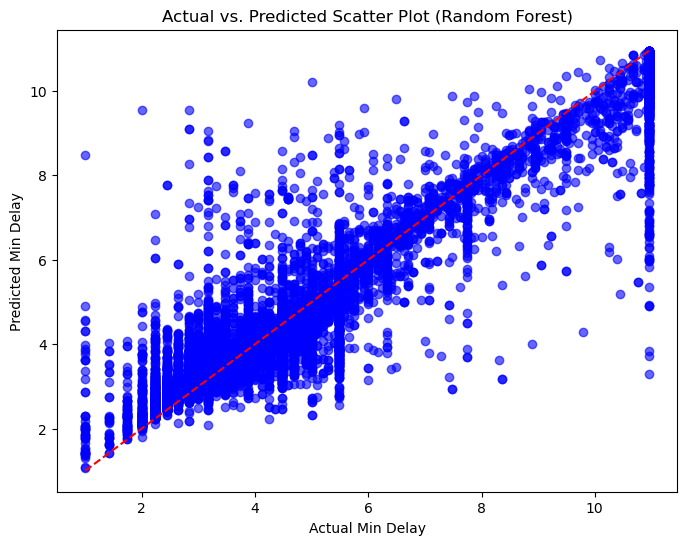

In [55]:
### Actual vs. Predicted Scatter plot using the optimal hyperparameter values

rf = RandomForestRegressor(
    
    n_estimators=200, 
    max_depth=None, 
    min_samples_leaf=1, 
    min_samples_split=2, 
    random_state=42,
    n_jobs=-1
    
)

rf.fit(X_train_scaled, y_train_scaled)

y_pred_scaled = rf.predict(X_test_scaled)

y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

y_actual = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

mse = mean_squared_error(y_actual, y_pred)

r2 = r2_score(y_actual, y_pred)

print(f"Test MSE: {mse:.4f}")

print(f"Test R² Score: {r2:.4f}")

plt.figure(figsize=(8, 6))

plt.scatter(y_actual, y_pred, alpha=0.6, color='blue')

plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], '--', color='red') 

plt.xlabel("Actual Min Delay")

plt.ylabel("Predicted Min Delay")

plt.title("Actual vs. Predicted Scatter Plot (Random Forest)")

plt.show()

### Balancing

### NN For balanced dataset

Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 10.

NN1_LR_0.1 with LR 0.1:
Train MSE: 0.9739
Validation MSE: 0.9500
Test MSE: 1.0417
Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 6.

NN1_LR_0.01 with LR 0.01:
Train MSE: 0.9579
Validation MSE: 0.9424
Test MSE: 1.0206
Epoch 65: early stopping
Restoring model weights from the end of the best epoch: 55.

NN1_LR_0.001 with LR 0.001:
Train MSE: 0.8814
Validation MSE: 0.8583
Test MSE: 0.9303
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.

NN2_LR_0.1 with LR 0.1:
Train MSE: 1.0003
Validation MSE: 0.9810
Test MSE: 1.0678
Epoch 39: early stopping
Restoring model weights from the end of the best epoch: 29.

NN2_LR_0.01 with LR 0.01:
Train MSE: 0.6894
Validation MSE: 0.6735
Test MSE: 0.7359
Epoch 71: early stopping
Restoring model weights from the end of the best epoch: 61.

NN2_LR_0.001 with LR 0.001:
Train MSE: 0.6294
Validation MSE: 0.6242

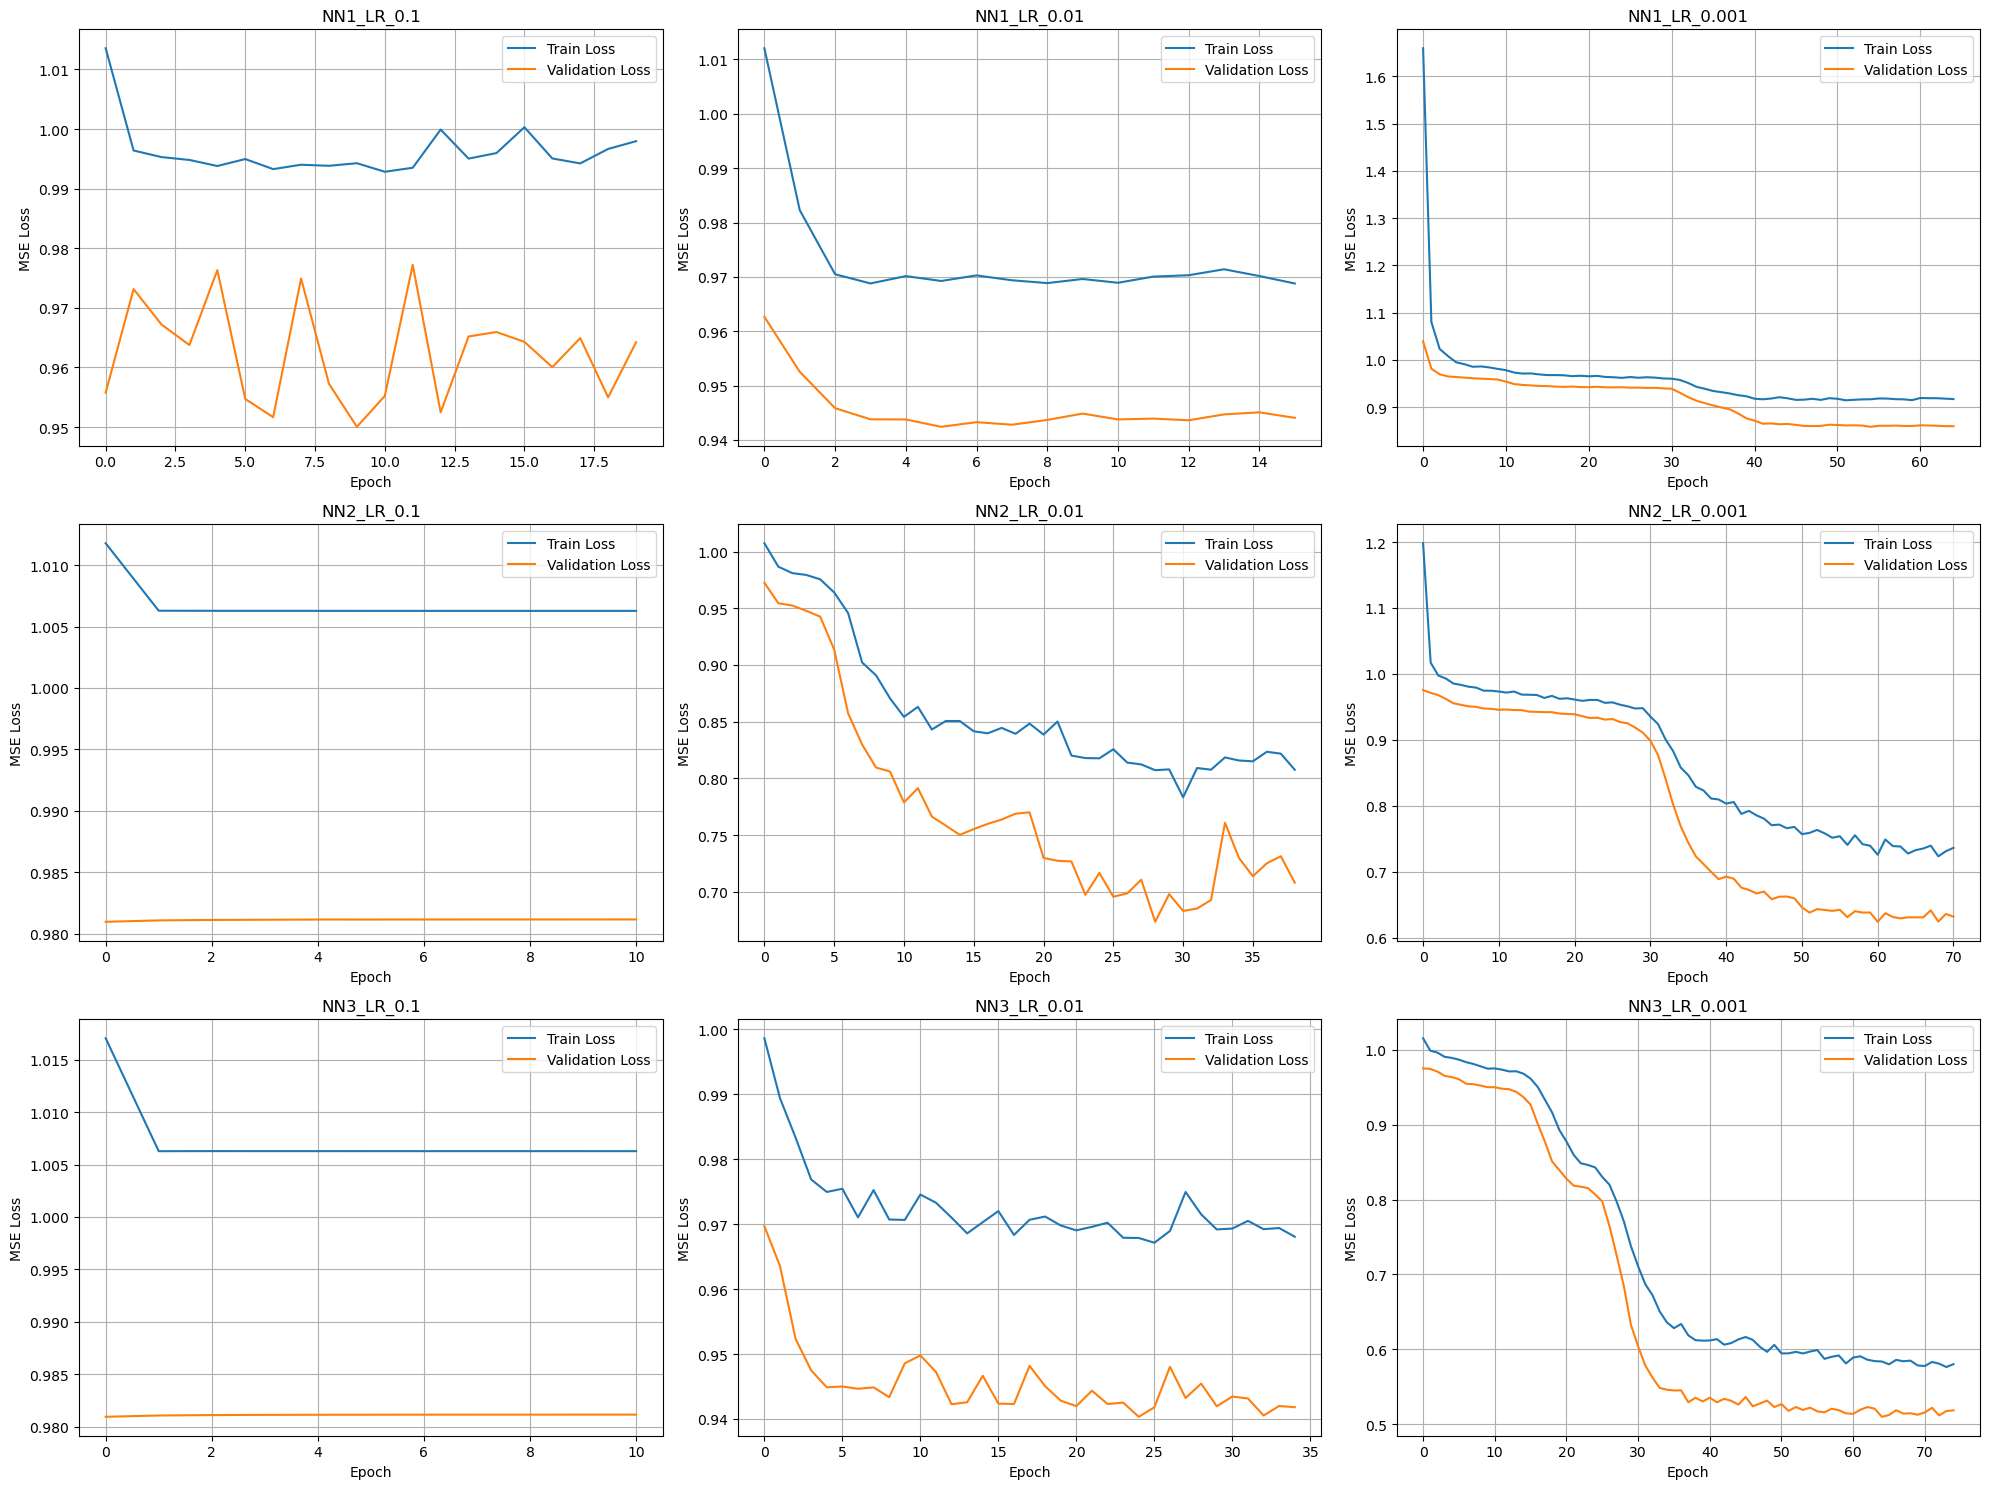


Best Model: NN3_LR_0.001
Best Validation Loss (MSE): 0.5097
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step

Final Test MSE: 2.2686


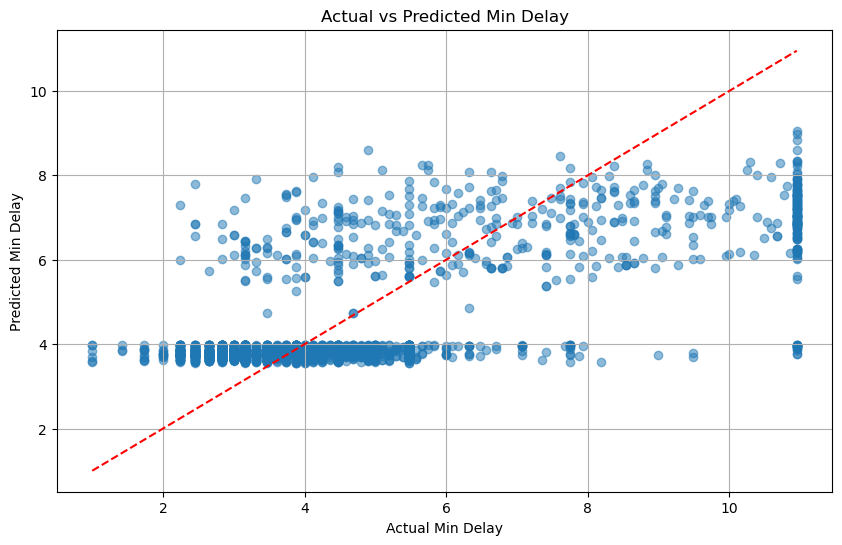


All files saved in: C:/Users/Asif/Jupyter Notebook/TTC/Balance/NN


In [63]:
SAVE_PATH = r'C:/Users/Asif/Jupyter Notebook/TTC/Balance/NN'

os.makedirs(SAVE_PATH, exist_ok=True)

np.random.seed(42)

tf.random.set_seed(42)


df = balanced_sample


X = df[['Day Hour', 'Day', 'Month', 'Incident', 'Lat', 'Lon', 'Mean Temp (°C)', 'Precipitation']]


y = df['Min Delay']


X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)


scaler_X = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()


early_stopping = EarlyStopping(
    
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
    
)


learning_rates = [0.1, 0.01, 0.001]


def create_and_train_model(model_name, hidden_layers, learning_rate, X_train, y_train, X_val, y_val, X_test, y_test):
   
    model_path = os.path.join(SAVE_PATH, f'{model_name}_model.keras')
    
    if os.path.exists(model_path):
        try:
            
            print(f"Loading existing model: {model_name}")
            
            model = tf.keras.models.load_model(model_path, compile=False)
            
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
            
            model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])
            
            return model, None
            
        except Exception as e:
            
            print(f"Error loading model: {e}. Creating new model.")
    
    model = Sequential(name=model_name)
    
    model.add(Dense(hidden_layers[0], activation='relu', input_shape=(X_train.shape[1],)))
    
    model.add(Dropout(0.2))
    
    for units in hidden_layers[1:]:
        
        model.add(Dense(units, activation='relu'))
        
        model.add(Dropout(0.2))
    
    model.add(Dense(1))  
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])
    
    checkpoint_path = os.path.join(SAVE_PATH, f'{model_name}_checkpoint.weights.h5')
    
    checkpoint = ModelCheckpoint(
        
        checkpoint_path, 
        save_weights_only=True, 
        save_best_only=True, 
        monitor='val_loss', 
        mode='min'
        
    )
    
    history = model.fit(
        
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, checkpoint],
        verbose=0
        
    )
    
    model.save(model_path)
    
    train_loss = model.evaluate(X_train, y_train, verbose=0)[0]
    
    val_loss = model.evaluate(X_val, y_val, verbose=0)[0]
    
    test_loss = model.evaluate(X_test, y_test, verbose=0)[0]
    
    
    print(f"\n{model_name} with LR {learning_rate}:")
    
    print(f"Train MSE: {train_loss:.4f}")
    
    print(f"Validation MSE: {val_loss:.4f}")
    
    print(f"Test MSE: {test_loss:.4f}")
    
    return model, history

results = []

best_models = {}


for lr in learning_rates:
    
    model_name = f"NN1_LR_{lr}"
    
    model, history = create_and_train_model(
        model_name, 
        [8], 
        lr,
        X_train_scaled, y_train_scaled, 
        X_val_scaled, y_val_scaled,
        X_test_scaled, y_test_scaled
        
    )
    
    results.append({
        
        'model_name': model_name,
        'lr': lr,
        'history': history,
        'model': model
        
    })


for lr in learning_rates:
    
    model_name = f"NN2_LR_{lr}"
    
    model, history = create_and_train_model(
        
        model_name, 
        
        [16, 8], 
        
        lr,
        
        X_train_scaled, y_train_scaled, 
        X_val_scaled, y_val_scaled,
        X_test_scaled, y_test_scaled
        
    )
    
    results.append({
        
        'model_name': model_name,
        'lr': lr,
        'history': history,
        'model': model
        
    })
    

for lr in learning_rates:
    
    model_name = f"NN3_LR_{lr}"
    model, history = create_and_train_model(
        model_name, 
        [32, 16, 8], 
        lr,
        X_train_scaled, y_train_scaled, 
        X_val_scaled, y_val_scaled,
        X_test_scaled, y_test_scaled
        
    )
    
    results.append({
        
        'model_name': model_name,
        'lr': lr,
        'history': history,
        'model': model
        
    })

plt.figure(figsize=(20, 15))


for i, result in enumerate(results):
    
    if result['history'] is not None:
        
        plt.subplot(3, 3, i+1)
        plt.plot(result['history'].history['loss'], label='Train Loss')
        plt.plot(result['history'].history['val_loss'], label='Validation Loss')
        plt.title(f"{result['model_name']}")
        plt.xlabel('Epoch')
        plt.ylabel('MSE Loss')
        plt.legend()
        
        plt.grid(True)
        
plt.tight_layout()

plt.savefig(os.path.join(SAVE_PATH, 'learning_curves.png'))

plt.show()

best_result = min(
    
    [r for r in results if r['history'] is not None], 
    key=lambda x: min(x['history'].history['val_loss'])
    
)


best_model_name = best_result['model_name']

best_val_loss = min(best_result['history'].history['val_loss'])

print(f"\nBest Model: {best_model_name}")

print(f"Best Validation Loss (MSE): {best_val_loss:.4f}")

best_model = best_result['model']

y_pred_scaled = best_model.predict(X_test_scaled).flatten()

y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

y_test_orig = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

test_mse = mean_squared_error(y_test_orig, y_pred)

print(f"\nFinal Test MSE: {test_mse:.4f}")


plt.figure(figsize=(10, 6))

plt.scatter(y_test_orig, y_pred, alpha=0.5)

plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--')

plt.xlabel('Actual Min Delay')

plt.ylabel('Predicted Min Delay')

plt.title('Actual vs Predicted Min Delay')

plt.grid(True)

plt.savefig(os.path.join(SAVE_PATH, 'actual_vs_predicted.png'))

plt.show()

with open(os.path.join(SAVE_PATH, 'model_summary.txt'), 'w', encoding='utf-8') as f:
    
    best_model.summary(print_fn=lambda x: f.write(x + '\n'))
    
print(f"\nAll files saved in: {SAVE_PATH}")

### Random Forest For balanced dataset

In [131]:
### Actual vs. Predicted Scatter plot using the optimal hyperparameter values

def random_forest_optimization(X_train_scaled, X_val_scaled, X_test_scaled, 
                                y_train, y_val, y_test):
    
    param_grid = {
        'n_estimators': [50, 100, 200], 
        'max_depth': [None, 10, 20],  
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
        
    }
    
    rf_model = RandomForestRegressor(random_state=42)
    
    grid_search = GridSearchCV(
        
        estimator=rf_model, 
        param_grid=param_grid, 
        cv=3, 
        scoring='neg_mean_squared_error', 
        n_jobs=2,  
        verbose=1
        
    )
    
    grid_search.fit(X_train_scaled, y_train)
    
    best_rf_model = grid_search.best_estimator_
    
    print("\nBest Random Forest Parameters:")
    
    print(grid_search.best_params_)
    
    y_train_pred = best_rf_model.predict(X_train_scaled)
    y_val_pred = best_rf_model.predict(X_val_scaled)
    y_test_pred = best_rf_model.predict(X_test_scaled)
    
    def compute_metrics(y_true, y_pred):
        
        return {
            
            'MSE': mean_squared_error(y_true, y_pred)
            
        }
    
    train_metrics = compute_metrics(y_train, y_train_pred)
    val_metrics = compute_metrics(y_val, y_val_pred)
    test_metrics = compute_metrics(y_test, y_test_pred)

    
    print("\nRandom Forest Regression Performance:")
    
    for metric_name in train_metrics.keys():
        
        print(f"\n{metric_name}:")
        print(f"Training: {train_metrics[metric_name]:.4f}")
        print(f"Validation: {val_metrics[metric_name]:.4f}")
        print(f"Testing: {test_metrics[metric_name]:.4f}")
    
    plt.figure(figsize=(10, 6))
    
    feature_importance = best_rf_model.feature_importances_
    feature_names = X.columns.tolist()  
    
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0])
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, [feature_names[i] for i in sorted_idx])
    
    plt.title('Feature Importance in Random Forest Model')
    
    plt.xlabel('Relative Importance')
    
    plt.tight_layout()
    
    plt.savefig('random_forest_feature_importance.png')
    
    plt.close()


    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_test_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    
    plt.title('Actual vs Predicted Min Delay (Random Forest)')
    
    plt.xlabel('Actual Min Delay')
    
    plt.ylabel('Predicted Min Delay')
    
    plt.tight_layout()
    
    plt.savefig('random_forest_actual_vs_predicted.png')
    
    plt.close()


    residuals = y_test - y_test_pred
    plt.figure(figsize=(10, 6))
    
    plt.scatter(y_test_pred, residuals, alpha=0.5)
    
    plt.title('Residual Plot (Random Forest)')
    
    plt.xlabel('Predicted Min Delay')
    
    plt.ylabel('Residuals')
    
    plt.axhline(y=0, color='r', linestyle='--')
    
    plt.tight_layout()
    
    plt.savefig('random_forest_residuals.png')
    
    plt.close()
    
    return best_rf_model, grid_search.best_params_

best_rf_model, best_params = random_forest_optimization(
    
    X_train_scaled, X_val_scaled, X_test_scaled, 
    y_train, y_val, y_test
    
)

Fitting 3 folds for each of 81 candidates, totalling 243 fits

Best Random Forest Parameters:
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Random Forest Regression Performance:

MSE:
Training: 0.2601
Validation: 1.3603
Testing: 1.4188
